# Time Series Forecasting(1): Initial analysis

María García Gumbao. [towardsdatascience.com](https://towardsdatascience.com/time-series-forecasting-1-initial-analysis-87e017501e98)

## Process

1. Loading the data and subsetting (I won’t be using the whole dataset here)
2. Visualizing the data
3. Cleaning the data: Are there missing values? Is all the data in the desired format?
4. Looking at the statistics: Are there outliers?
5. Looking for stationarity and autocorrelation
6. Trend and seasonality decomposition

## The Data

Using: Historical Hourly Weather Data 2012-2017. [Kaggle's repository](https://www.kaggle.com/selfishgene/historical-hourly-weather-data/home)

This dataset contains ~5 years of weather information for different cities, including information about the temperature, humidity, pressure, wind and description of the weather. I am going to focus on temperature data, since it’s the property I find to be more intuitive.

To do the examples I’m going to use the temperature data for two cities, the chosen ones will be San Francisco (because I like it) and the city with the highest variation.

### 1. Loading the data

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [6]:
temp = pd.read_csv('.\\data\\temperature.data.csv', parse_dates=['datetime'])

# set the datetime column as the index.
temp = temp.set_index('datetime')

print('Dataset shape: {}'.format(temp.shape))

temp.head()

Dataset shape: (45253, 36)


,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,...,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,309.100000,NaN,NaN,NaN
2012-10-01 13:00:00,284.630000,282.080000,289.480000,281.800000,291.870000,291.530000,293.410000,296.600000,285.120000,284.610000,...,285.630000,288.220000,285.830000,287.170000,307.590000,305.470000,310.580000,304.4,304.4,303.5
2012-10-01 14:00:00,284.629041,282.083252,289.474993,281.797217,291.868186,291.533501,293.403141,296.608509,285.154558,284.607306,...,285.663208,288.247676,285.834650,287.186092,307.590000,304.310000,310.495769,304.4,304.4,303.5
2012-10-01 15:00:00,284.626998,282.091866,289.460618,281.789833,291.862844,291.543355,293.392177,296.631487,285.233952,284.599918,...,285.756824,288.326940,285.847790,287.231672,307.391513,304.281841,310.411538,304.4,304.4,303.5
2012-10-01 16:00:00,284.624955,282.100481,289.446243,281.782449,291.857503,291.553209,293.381213,296.654466,285.313345,284.592530,...,285.850440,288.406203,285.860929,287.277251,307.145200,304.238015,310.327308,304.4,304.4,303.5


### 2. Visualizing the data

In [9]:
# use one with the highest variation in yearly temperature
all_std = temp.std(axis=0)
max_std = all_std.max()
city_max_std = temp.columns[all_std==max_std][0]

print('City with highest temperature variation: {} ({} degrees)'.format(city_max_std, round(max_std,2)))

City with highest temperature variation: Minneapolis (12.77 degrees)


In [10]:
# subset the data, it only contains values for San Francisco and Minneapolies
data = temp[['San Francisco','Minneapolis']]
data.describe()

,San Francisco,Minneapolis
count,44460.000000,45240.000000
mean,288.155821,280.700489
std,5.332862,12.774979
min,272.300000,242.336667
25%,284.670000,271.790000
50%,287.610000,281.639000
75%,291.015167,291.310000
max,313.620000,308.240000


First thing I see is that there are missing data in both columns, I’ll deal with that soon. Also, this temperature values are obviously not in a normal scale for day-to-day temperature. Since I live in Europe I’m going to transform the data from Kelvin to Celsius (sorry if you use Farenheit, but International Systemm baby).

In [11]:
data = data-273.15
data.describe()

,San Francisco,Minneapolis
count,44460.000000,45240.000000
mean,15.005821,7.550489
std,5.332862,12.774979
min,-0.850000,-30.813333
25%,11.520000,-1.360000
50%,14.460000,8.489000
75%,17.865167,18.160000
max,40.470000,35.090000


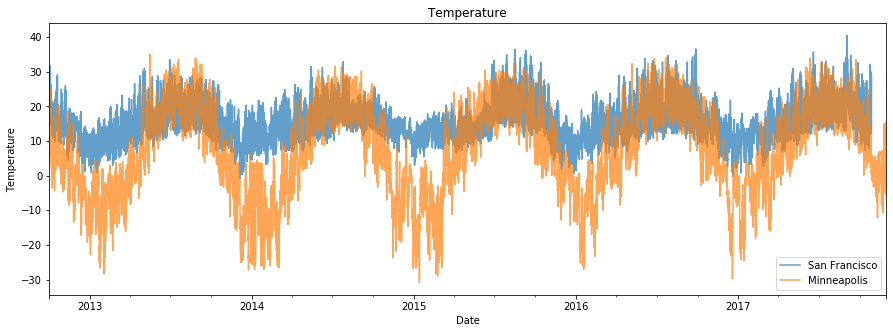

In [23]:
_=data.plot(
    figsize=(15,5),
    subplots=False,   ## subplots=True,
    title='Temperature',
    alpha=0.7
)
_=plt.xlabel('Date')
_=plt.ylabel('Temperature')

#### Analysis:

The weather seems quite cold in Minneapolis, maybe I wouldn’t go there during the winter.
Also, there is a clear seasonality in the data with a period of a year. There is also more variation, I’ll check later if this variation has something to do with some daily seasonality or it’s more random.

Something I can see in this figure is that we have less data for San Francisco. The blue line doesn’t get that close to 2018.

### 3. Cleaning the data

As we saw, there are clearly missing values, something that caughts my attention in the figure may be a reason for this. As I mentioned, the data for San Francisco finishes earlier, to work with both series at the same time I’m going to lose the final values in the Minneapolis series.

To do so I’m going to keep all the non-missing values of San Francisco and see the maximum date they reach. Then, we’ll cut all data with date larger than that.

In [24]:
SF_non_missing = data['San Francisco'].dropna()
max_date = SF_non_missing.index.max()
data = data[data.index <= max_date]

Let’s see if we still have missing values.

In [25]:
print(data.isna().sum())

San Francisco     1
Minneapolis      13
dtype: int64


Ok, we still have to deal with the problem of missing data, but there is something I want to deal with first. My intention here is to study the yearly behaviour of the data, I’m not interested in the daily variation, so I’m going to resample(`muestrear`) the data into a daily frequency by taking the average, minimum and maximum of all the temperatures through that day.

In [41]:
data_week = data.resample('W').mean()
data_mean = data.resample('D').mean()
data_min = data.resample('D').min()
data_max = data.resample('D').max()
print('Resample shape: {}'.format(data_mean.shape))
data_mean.describe()

Resample shape: (1854, 2)


,San Francisco,Minneapolis
count,1854.000000,1854.000000
mean,15.013381,7.667746
std,4.047529,12.385574
min,2.970833,-24.687187
25%,12.271016,-1.058090
50%,14.938721,9.011625
75%,17.918520,18.690818
max,29.487500,30.538125


In [42]:
print('Missing data now?')
print(data_mean.isna().sum())

Missing data now?
San Francisco    0
Minneapolis      0
dtype: int64


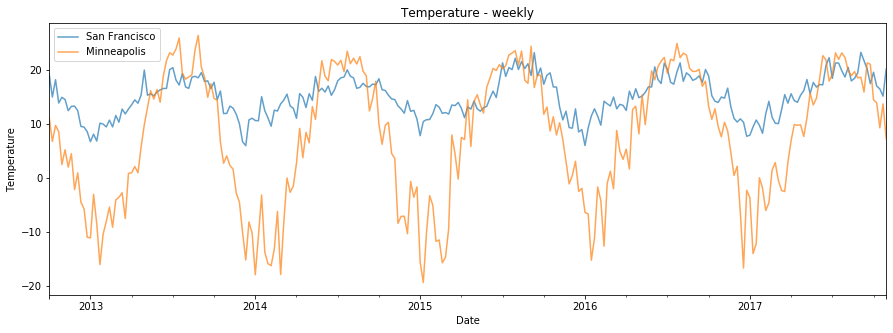

In [43]:
_=data_week.plot(
    figsize=(15,5),
    subplots=False,   ## subplots=True,
    title='Temperature - weekly',
    alpha=0.7
)
_=plt.xlabel('Date')
_=plt.ylabel('Temperature')

No missing data now! This means that we have at least one value per day.

**If this were not the case I would have used the values from the previus day. I like this solution for time series more than just dropping the row (is better to have the same temporal separation between all rows) or just using the mean value (since this would mess with the shape of the curve)**.

Let’s check how our data looks after resampling.

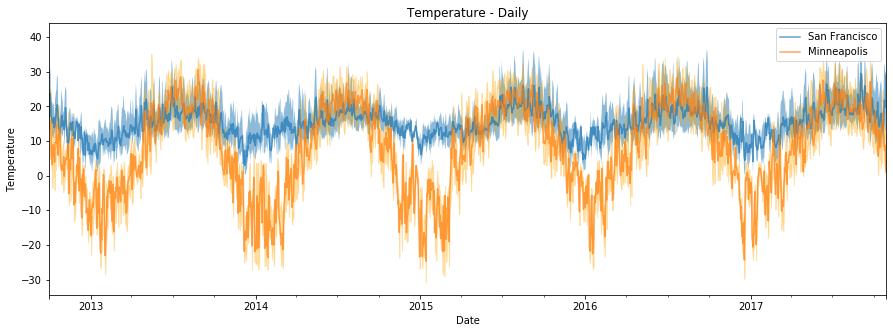

In [49]:
_=data_mean.plot(
    figsize=(15,5),
    subplots=False,
    title='Temperature - Daily',
    alpha=0.7
)
_=plt.fill_between(
    x=data_mean.index,
    y1=data_min['San Francisco'].values,
    y2=data_max['San Francisco'].values,
    alpha=0.5
)
_=plt.fill_between(
    x=data_mean.index,
    y1=data_min['Minneapolis'].values,
    y2=data_max['Minneapolis'].values,
    color='orange',
    alpha=0.3
)
_=plt.xlabel('Date')
_=plt.ylabel('Temperature')

The shadow around the curve shows the min-max values during that day, while the main line shows the mean value.

Now both curves end at the same point, and we have less daily variation.

### 4. Outliers

Some times weird things happen and we end up with values that can mess up an entire model. One sensor can fail, for example, and measure a temperature of -10º in summer, which definitely is not normal. Other times you can see 10º in the summer, that’s low, but maybe not an error, sometimes it can get cold, you can’t remove this type of value, because there can be some reason to it. We have to be carefull how we treat outliers, we shouldn’t remove it unless we know it’s an error or is a one-time-thing that shouldn’t affect our model.

It’s not always easy to identify which points are outliers, and what to do with them, but a good place to start is to inspect the data to see if there are points with extremely high or low values. One good way to see this visually is to use histograms.

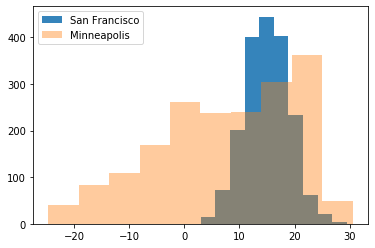

In [57]:
_=plt.hist(data_mean['San Francisco'], alpha=0.9, label='San Francisco')
_=plt.hist(data_mean['Minneapolis'], alpha=0.4, label='Minneapolis')
_=plt.legend()

Let’s look into each of the cities individually:

- Values for San Francisco seem to follow a gaussian distribution with a small standard deviation, we can’t see any outliers in this data.
- For Minneapolis the curve is less perfect, with a high skewness to the right side (negative skewness). We cannot say that any of this points are outliers though, since there is quite a few of them, also, in the visual representation of the temperatures we could see that really low values are reached every year.

I don’t see any outliers and don’t think I should remove any points.

### 5. Looking for stationarity and autocorrelation

This gaussian-shaped histagram we plotted earlier is a first clue the time series can be stationary.

Another clue is to compute some statistics on the time series in different time ranges and looking for a variation.

In [58]:
cut = data_mean.index[int(0.5*len(data_mean))]
print('Mean before {}:'.format(cut))
print(data_mean.loc[:cut].mean())
print('')
print('Mean after {}:'.format(cut))
print(data_mean.loc[cut:].mean())
print('')
print('---------------------------')
print('')
print('Std before {}:'.format(cut))
print(data_mean.loc[:cut].std())
print('')
print('Std after {}:'.format(cut))
print(data_mean.loc[cut:].std())

Mean before 2015-04-16 00:00:00:
San Francisco    14.165476
Minneapolis       4.474264
dtype: float64

Mean after 2015-04-16 00:00:00:
San Francisco    15.863599
Minneapolis      10.873516
dtype: float64

---------------------------

Std before 2015-04-16 00:00:00:
San Francisco     3.568757
Minneapolis      13.069418
dtype: float64

Std after 2015-04-16 00:00:00:
San Francisco     4.311676
Minneapolis      10.748980
dtype: float64


We can see that the values are pretty close for San Francisco, but further away for Minneapolis, they are still close enough for the time series to be stationary since we need to take into account the standard deviation.

This method doesn’t prove or deny that our time series are stationary, it’s just indicates that it can be.

We can also use a statistical test to see if the non-stationarity hypothesis should be rejected **Augmented Dickey-Fuller test**.

In [60]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data_mean['San Francisco'])

print('San Francisco')
print('--------------------------')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
print('\n\n')
    
result = adfuller(data_mean['Minneapolis'])
print('Minneapolis')
print('--------------------------')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

San Francisco
--------------------------
ADF Statistic: -3.642015
p-value: 0.005007
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568



Minneapolis
--------------------------
ADF Statistic: -2.589836
p-value: 0.095116
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


So, what do any of these values mean?

- The ADF Statistic is the Augmented Dicken-Fuller score, **the more negative this value is, the higher the certainty that we can reject out null hypothesis (the probability that the time series is stationary)**.

- p-value is the level of confidance for the null hypothesis. A usual threshold for this value is 0.05, meaning that if p_value <= 0.05 we can reject the null hypothesis.

- The rest of the values are the critical values for a 99%, 95% and 90% confidence intervals respectively.

`So, what all this means in this case is that we can reject the null hypothesis for San Francisco since p is lower than 0.05, and also, the ADF score is lower than the limit for a 99% confidence interval. However, we fail to reject this hypothesis for Minneapolis, we could say it is stationarity with a confidence interval of 90%, but since the threshold was 95% (p = 0.05), we cannot reject it. This means we should difference the data before applying any model`.

Some references to understand this tests can be found here:
- [Stationary Data Tests for Time Series Forecasting](https://pythondata.com/stationary-data-tests-for-time-series-forecasting/).
- [How to Check if Time Series Data is Stationary with Python](https://machinelearningmastery.com/time-series-data-stationary-python/).

#### Autocorrelation

Last thing to check is if the data is autocorrelated. I want to use some autoregression methods to do forecasting in future posts, I can only do that if the data is autocorrelated (meaning that the value in a specific temporal point depends on previous values).

The `statmodels library` offers a great tool to check this. **Everything outside of the shadowed area has a strong probability of being autocorrelated (over 95% confidence interval)**.

San Francisco


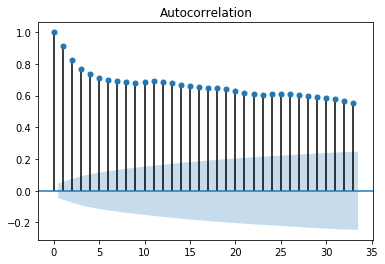

Minneapolis


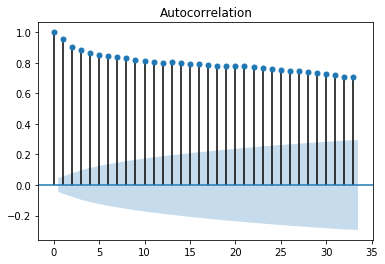

In [61]:
import statsmodels.api as sm

print('San Francisco')
_=sm.graphics.tsa.plot_acf(data_mean['San Francisco'])
plt.show()

print('Minneapolis')
_=sm.graphics.tsa.plot_acf(data_mean['Minneapolis'])
plt.show()

Let’s focus on the most important lags (the ones closer to the point), for example, data from one-year range.

San Francisco


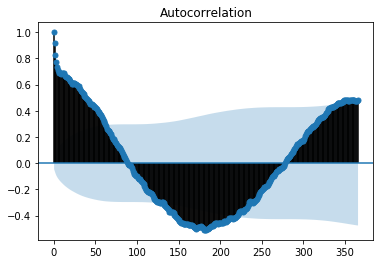

Minneapolis


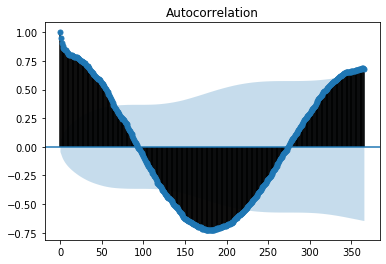

In [62]:
import statsmodels.api as sm

print('San Francisco')
_=sm.graphics.tsa.plot_acf(data_mean['San Francisco'], lags=365)
plt.show()

print('Minneapolis')
_=sm.graphics.tsa.plot_acf(data_mean['Minneapolis'], lags=365)
plt.show()

We can also check for partial autocorrelation, which calculates the correlation removing the effect of any other previous point (points closer to the new value). Here further away points lose importance, I'll focus on one-month range.

San Francisco


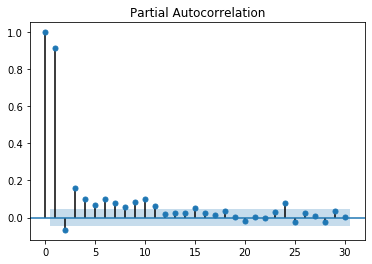

Minneapolis


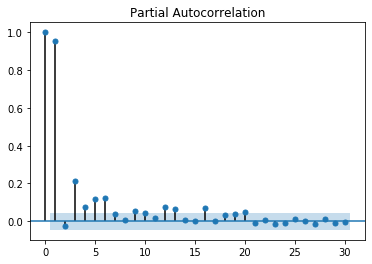

In [63]:
print('San Francisco')
_=sm.graphics.tsa.plot_pacf(data_mean['San Francisco'], lags=30)
plt.show()

print('Minneapolis')
_=sm.graphics.tsa.plot_pacf(data_mean['Minneapolis'], lags=30)
plt.show()

Here are some references about autocorrelation:
    
- [Statsmodels reference to `acf` function](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.acf.html)
- [Statsmodels reference to `pacf` function](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.pacf.html)
- [A Gentle Introduction to Autocorrelation and Partial Autocorrelation](https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/)


### 6. Trend — Seasonality decomposition

We can think about time series as a composition of trend, seasonality and residuals (noise or other random behaviour). The composition of the time series from this components can be bouth aditive or multiplicative:

- `Additive`: data = Trend + Seasonality + Residuals
- `Multiplicative`: data = Trend · Seasonality · Residuals

The Statsmodels package offers a function to extract this 3 component at once: [Seasonal_decompose](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html)

The decomposition here is easy because we know the period to be 365 days.

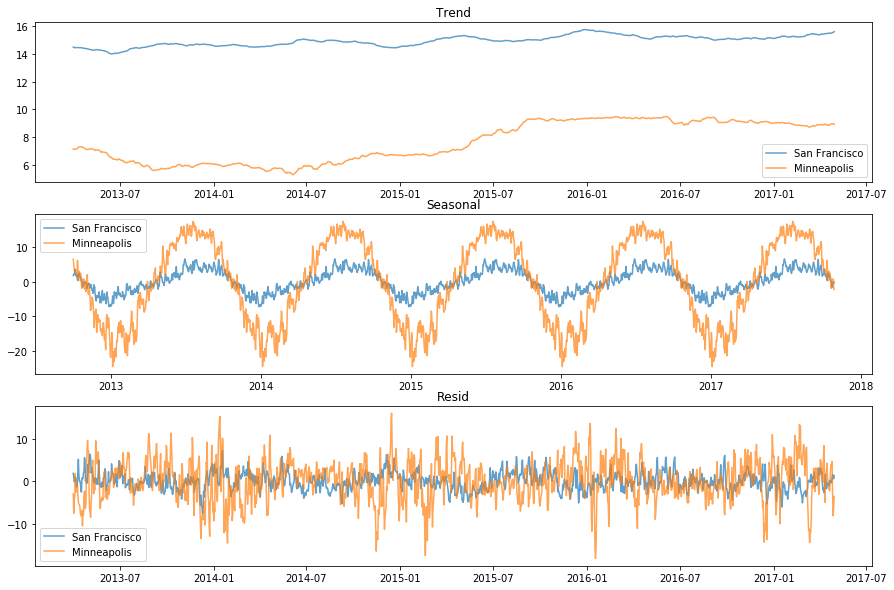

In [67]:
from statsmodels.tsa.seasonal import seasonal_decompose as sd

sd_SF = sd(data_mean['San Francisco'], freq=365)
sd_M = sd(data_mean['Minneapolis'], freq=365)

_=plt.figure(figsize=(15,10))

ax1=plt.subplot(311, title='Trend')
_=ax1.plot(sd_SF.trend, label='San Francisco', alpha=0.7)
_=ax1.plot(sd_M.trend, label='Minneapolis', alpha=0.7)
_=plt.legend()

ax2=plt.subplot(312, title='Seasonal')
_=ax2.plot(sd_SF.seasonal, label='San Francisco', alpha=0.7)
_=ax2.plot(sd_M.seasonal, label='Minneapolis', alpha=0.7)
_=plt.legend()

ax3=plt.subplot(313, title='Resid')
_=ax3.plot(sd_SF.resid, label='San Francisco', alpha=0.7)
_=ax3.plot(sd_M.resid, label='Minneapolis', alpha=0.7)
_=plt.legend()

Looking at this we can understand why we found the Minneapolis data to be non-stationary, there has been a clear increase in the temperature.

We can also find the trend by doing the moving average, I won’t do that here since it’s what the seasonal_decompose function does behing the scenes.